In [2]:
## Manipulación de datos
import pandas as pd
import numpy as np

## Visualización
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Modelos
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,r2_score,mean_absolute_percentage_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge,BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import StackingRegressor
import statsmodels.api as sm
import shap

In [3]:
df = pd.read_csv(r'..\..\data\processed\Merch_ML.csv')
tienda = df.copy()
df.head()

,Order_ID,Order_Date,Buyer_Age,Sales_Price,Shipping_Charges,Sales_per_Unit,Quantity,Total_Sales,Rating,Product_ID,Order_Location,International_Shipping,Buyer_Gender,Product_Category_Clothing,Product_Category_Ornaments,Product_Category_Other
0,189440,2024-07-21,30,100,0,100,1,100,4,0,15,0,1,1.0,0.0,0.0
1,187385,2024-07-20,32,100,0,100,1,100,3,0,6,0,1,1.0,0.0,0.0
2,181844,2024-07-21,26,9,40,49,1,49,2,1,1,1,0,0.0,0.0,1.0
3,197934,2024-08-19,28,9,0,9,2,18,3,1,18,0,1,0.0,0.0,1.0
4,122470,2024-01-06,19,10,0,10,3,30,5,2,11,0,0,0.0,0.0,1.0


In [4]:
df.rename(columns={'Sales_per_Unit':'Ventas_X_Unidad','Quantity':'Cantidad_Productos'},inplace=True)

In [5]:
df['Numero_pedidos'] = 1
# Añadimos un 1 por cada orden realizada, para mas adelante poder tener el numero de pedidos total.

In [6]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

In [7]:
df.sort_values(by='Order_Date',inplace=True)

In [8]:
df = df.groupby('Order_Date').sum()
# Agrupamos por dia todas las ventas

In [9]:
df = df.asfreq('D')
# aplicamos la frecuencia Diaria

In [10]:
df['semana_anio'] = df.index.isocalendar().week  # Para semanas del año
df['diasemana'] = df.index.dayofweek  # 0 = Lunes, 6 = Domingo
df['findesem'] = (df['diasemana'] >= 5).astype(int)  # 1 = Fin de semana

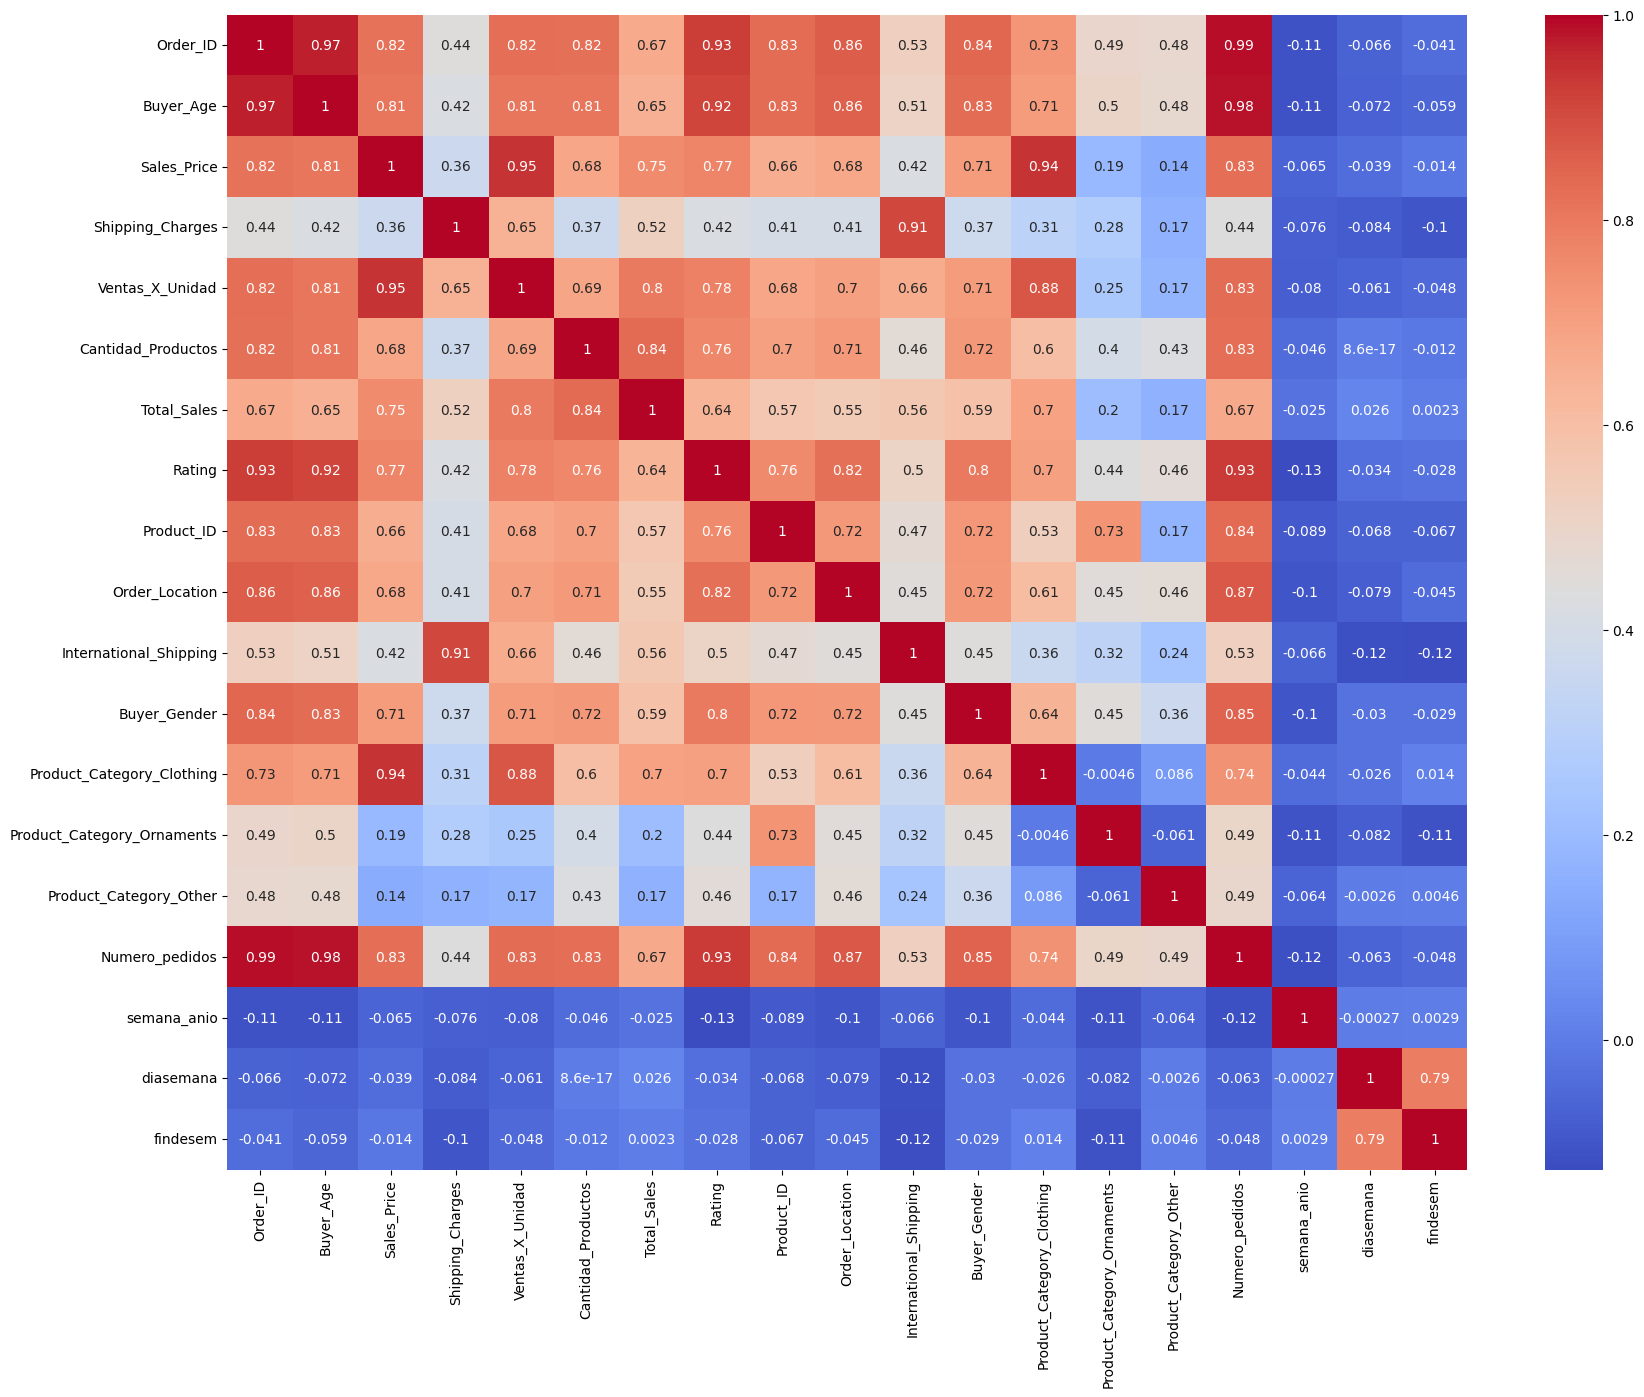

In [11]:
corr = df.corr()

plt.figure(figsize=(20,15))
sns.heatmap(corr,annot=True,cmap='coolwarm');

In [12]:
df['M_CantidadP_NumP'] = df['Cantidad_Productos'] / df['Numero_pedidos']  # Promedio de productos por pedido
df['Order_to_Product_Ratio'] = df['Numero_pedidos'] / df['Cantidad_Productos']  # Ratio de pedidos a productos
df['Pedidos_x_Cantidad'] = df['Numero_pedidos'] * df['Cantidad_Productos']

In [13]:
df.drop(columns=(['Buyer_Age','Rating','Product_ID','Order_Location','Order_ID',
                  'International_Shipping','Buyer_Gender','Product_Category_Clothing',
                  'Product_Category_Ornaments','Product_Category_Other','Sales_Price','semana_anio','Shipping_Charges','findesem']),inplace=True)
# Eliminamos columnas irrelevantes.

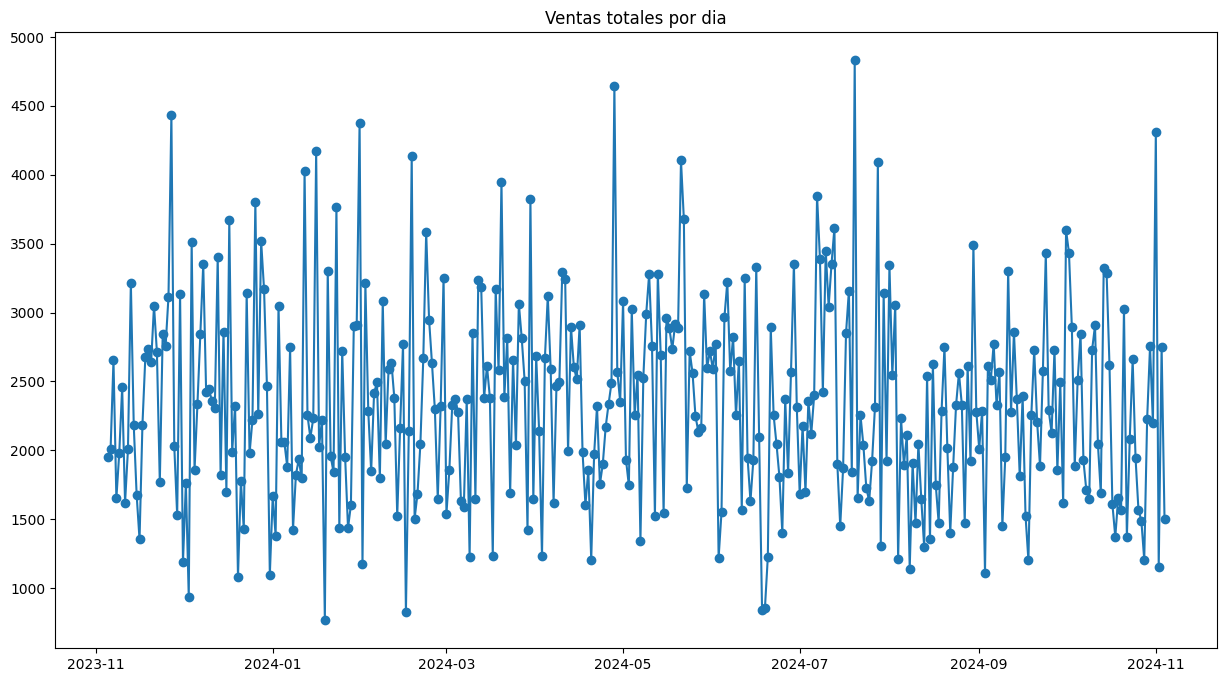

In [14]:
plt.figure(figsize=(15,8))
plt.plot(df.index, df['Total_Sales'], label='Ventas Reales', marker='o')
plt.title('Ventas totales por dia');

In [15]:
resultados = {}

# Función para evaluar un modelo y guardar resultados
def evaluar_modelo(nombre,y_pred,y_test):
  
    # Calcular métricas
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Guardar en el diccionario
    resultados[nombre] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}

In [16]:
train = df.iloc[:290]
test = df.iloc[290:]
# Definimos train y test

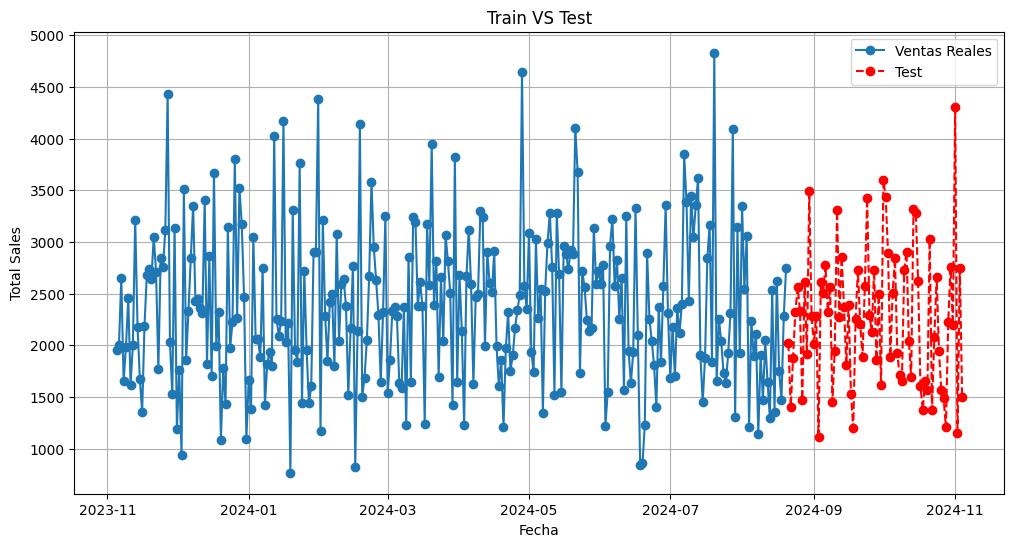

In [17]:
plt.figure(figsize=(12,6))

# Graficar las ventas reales
plt.plot(train.index, train['Total_Sales'], label='Ventas Reales', marker='o')

# Graficar predicciones en Test
plt.plot(test.index, test['Total_Sales'], label='Test', linestyle='dashed', marker='o', color='red')

# Configurar la gráfica
plt.xlabel('Fecha')
plt.ylabel('Total Sales')
plt.title('Train VS Test')
plt.legend()
plt.grid()
plt.show()

In [18]:
X_train_1, y_train = train.drop(columns=['Total_Sales']), train['Total_Sales']
X_test_1, y_test = test.drop(columns=['Total_Sales']), test['Total_Sales']
# Separamos la target y las variables.

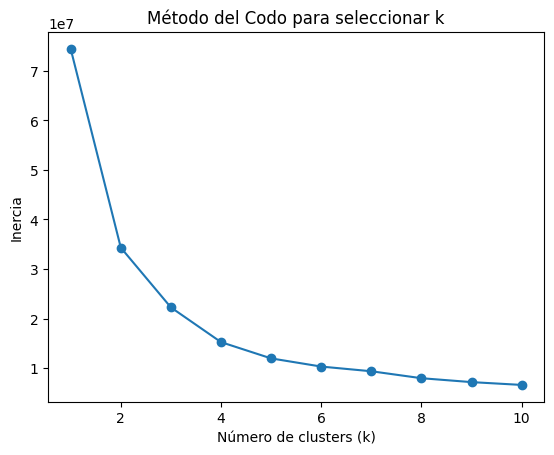

In [19]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(1, 11)  # Probar entre 1 y 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_1)
    inertia.append(kmeans.inertia_)  # Inercia = suma de distancias dentro del cluster

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para seleccionar k')
plt.show()

In [20]:
kmeans = KMeans(n_clusters=3, random_state=42)
X_train_1['Cluster'] = kmeans.fit_predict(X_train_1)
X_test_1['Cluster'] = kmeans.predict(X_test_1)

X_train = pd.get_dummies(X_train_1, columns=['Cluster'],dtype=float)
X_test = pd.get_dummies(X_test_1, columns=['Cluster'],dtype=float)

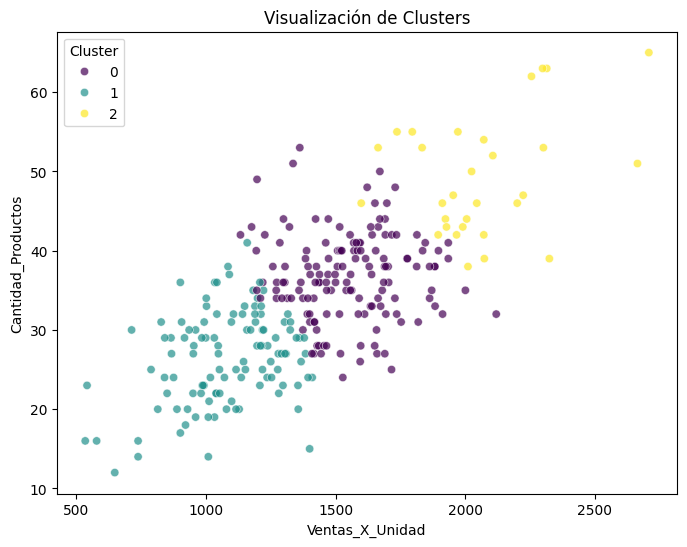

In [21]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_1['Ventas_X_Unidad'], y=X_train_1['Cantidad_Productos'], hue=X_train_1['Cluster'], palette='viridis', alpha=0.7)
plt.title("Visualización de Clusters")
plt.legend(title="Cluster")
plt.show()

### XGBoost

In [22]:
y_train_log = np.log1p(y_train)

In [26]:
xgb = XGBRegressor()

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

rmse = root_mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
mape = mean_absolute_percentage_error(y_test,y_pred)
print(f'MAPE: {mape*100:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
evaluar_modelo('XGBoost',y_pred=y_pred,y_test=y_test)

MAPE: 10.34%
RMSE: 280.4390
MAE: 233.6590


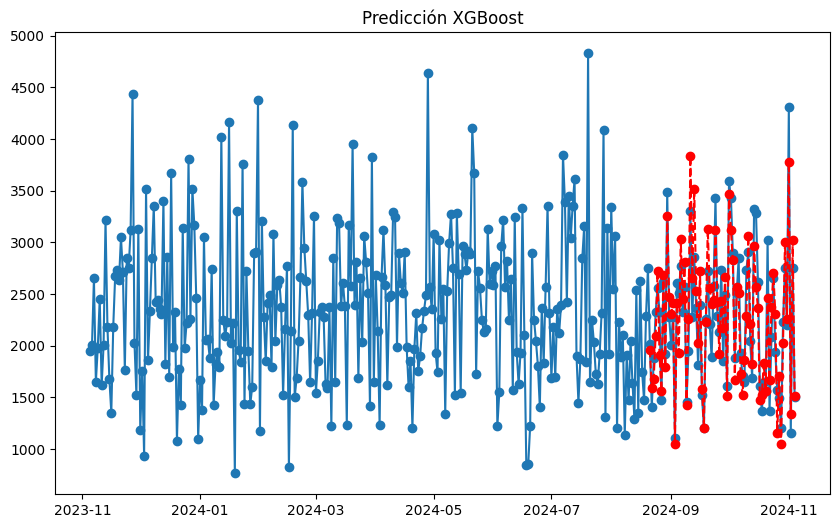

In [23]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Total_Sales'], label='Ventas Reales', marker='o')
plt.plot(test.index, y_pred, label='Predicción XGBOOST', linestyle='dashed', marker='o', color='red')
plt.title('Predicción XGBoost');

### LGBMRegressor

In [27]:
lgb = LGBMRegressor(verbose=-1)

lgb.fit(X_train, y_train_log)

lgb_pred = lgb.predict(X_test)
lgb_pred = np.expm1(lgb_pred)

rmse = root_mean_squared_error(y_test,lgb_pred)
mae = mean_absolute_error(y_test,lgb_pred)
mape = mean_absolute_percentage_error(y_test,lgb_pred)
print(f'MAPE: {mape*100:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
evaluar_modelo('LGBMRegressor',y_pred=lgb_pred,y_test=y_test)

MAPE: 9.44%
RMSE: 261.4881
MAE: 211.5041


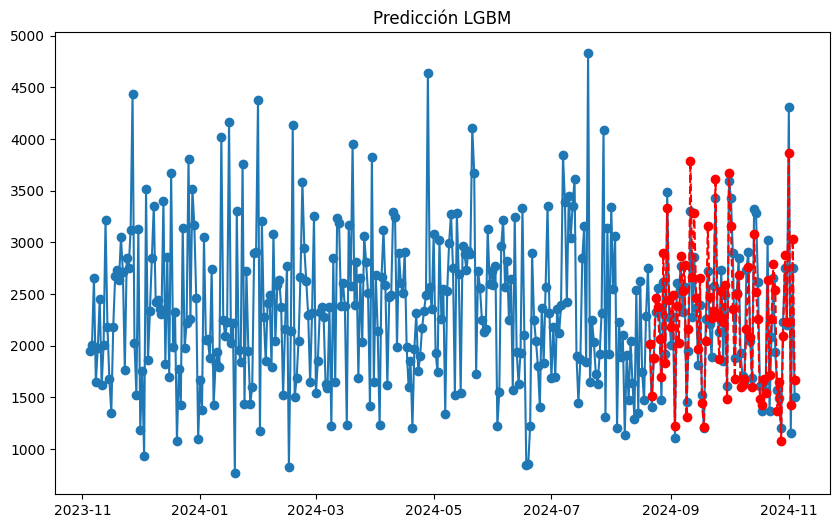

In [25]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Total_Sales'], label='Ventas Reales', marker='o')
plt.plot(test.index, lgb_pred, label='Predicción LGBM', linestyle='dashed', marker='o', color='red')
plt.title('Predicción LGBM');

### RandomForest

In [28]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

rmse = root_mean_squared_error(y_test,rf_pred)
mae = mean_absolute_error(y_test,rf_pred)
mape = mean_absolute_percentage_error(y_test,rf_pred)
print(f'MAPE: {mape*100:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
evaluar_modelo('RandomForestRegressor',y_pred=rf_pred,y_test=y_test)

MAPE: 8.35%
RMSE: 246.0310
MAE: 189.6733


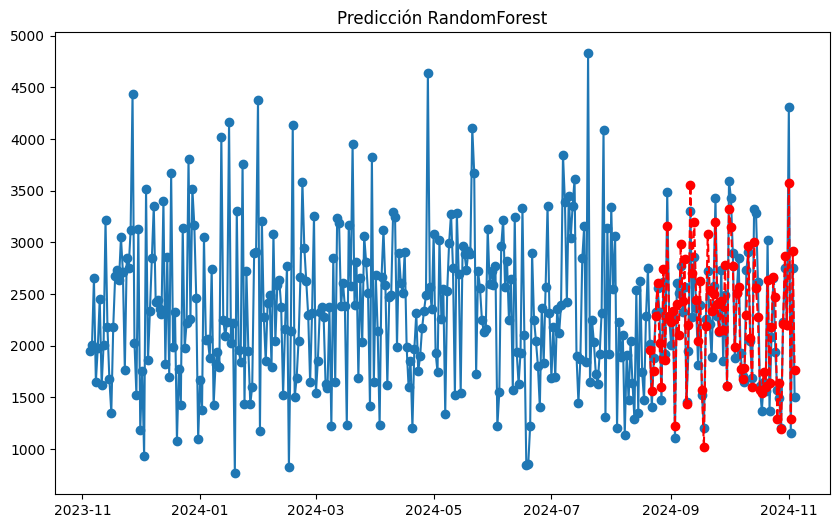

In [29]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Total_Sales'], label='Ventas Reales', marker='o')
plt.plot(test.index, rf_pred, label='Predicción RandomForest', linestyle='dashed', marker='o', color='red')
plt.title('Predicción RandomForest');

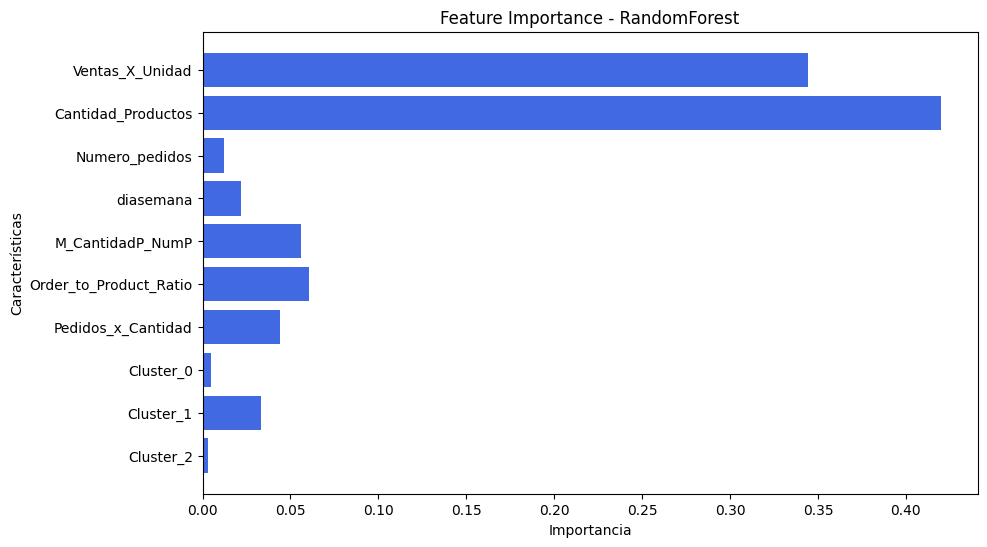

In [30]:
feature_importances = rf.feature_importances_

# Crear un DataFrame con la importancia de las características
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,  # Usar los nombres reales de las columnas seleccionadas
    "Importance": feature_importances
})


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="royalblue")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Feature Importance - RandomForest")
plt.gca().invert_yaxis()
plt.show()

### Linear regression

In [31]:
lr = LinearRegression()

lr.fit(X_train, y_train_log)

lr_pred = lr.predict(X_test)
lr_pred = np.expm1(lr_pred)

rmse = root_mean_squared_error(y_test,lr_pred)
mae = mean_absolute_error(y_test,lr_pred)
mape = mean_absolute_percentage_error(y_test,lr_pred)
print(f'MAPE: {mape*100:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
evaluar_modelo('LinearRegression',y_pred=lr_pred,y_test=y_test)

MAPE: 6.49%
RMSE: 187.2547
MAE: 144.3152


In [32]:
X_train_sm = sm.add_constant(X_train_1, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train_sm,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Sales   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     272.3
Date:                Wed, 02 Apr 2025   Prob (F-statistic):          1.42e-127
Time:                        08:57:10   Log-Likelihood:                -2015.5
No. Observations:                 290   AIC:                             4049.
Df Residuals:                     281   BIC:                             4082.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     78

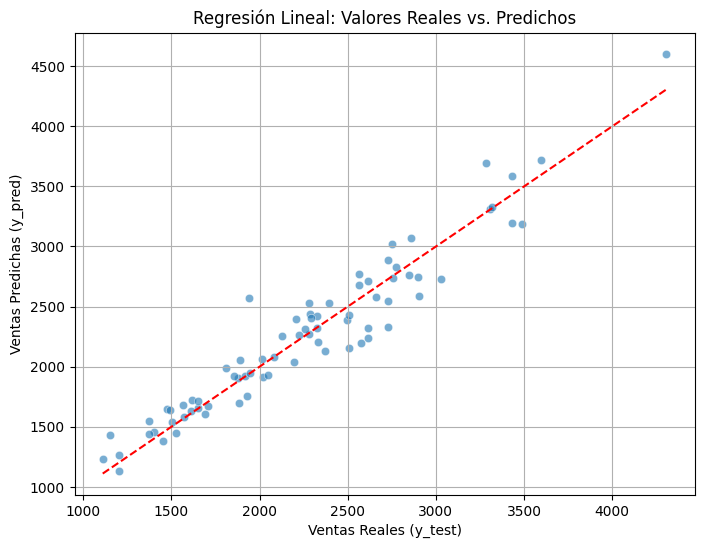

In [33]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=lr_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Ventas Reales (y_test)")
plt.ylabel("Ventas Predichas (y_pred)")
plt.title("Regresión Lineal: Valores Reales vs. Predichos")
plt.grid()
plt.show()

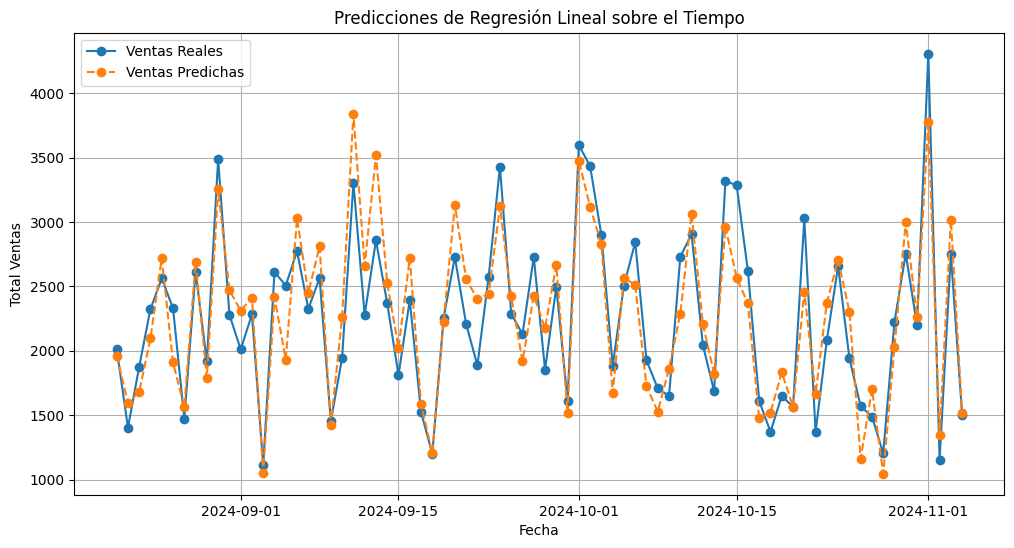

In [34]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Ventas Reales", marker='o', linestyle='-')
plt.plot(y_test.index, y_pred, label="Ventas Predichas", marker='o', linestyle='--')
plt.xlabel("Fecha")
plt.ylabel("Total Ventas")
plt.title("Predicciones de Regresión Lineal sobre el Tiempo")
plt.legend()
plt.grid()
plt.show()

### SVM

In [35]:
svr = SVR(kernel='linear')

svr.fit(X_train, y_train)

svr_pred = svr.predict(X_test)

rmse = root_mean_squared_error(y_test,svr_pred)
mae = mean_absolute_error(y_test,svr_pred)
mape = mean_absolute_percentage_error(y_test,svr_pred)
print(f'MAPE: {mape*100:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
evaluar_modelo('SVR',y_pred=svr_pred,y_test=y_test)


MAPE: 6.52%
RMSE: 186.9833
MAE: 144.3000


In [36]:
feature_importances = np.abs(svr.coef_).flatten()

importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importances_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
2,Numero_pedidos,83.184401
1,Cantidad_Productos,62.620012
3,diasemana,11.068055
4,M_CantidadP_NumP,8.486194
8,Cluster_1,4.890953
5,Order_to_Product_Ratio,3.244156
9,Cluster_2,3.043705
7,Cluster_0,1.847248
0,Ventas_X_Unidad,1.468118
6,Pedidos_x_Cantidad,0.098850


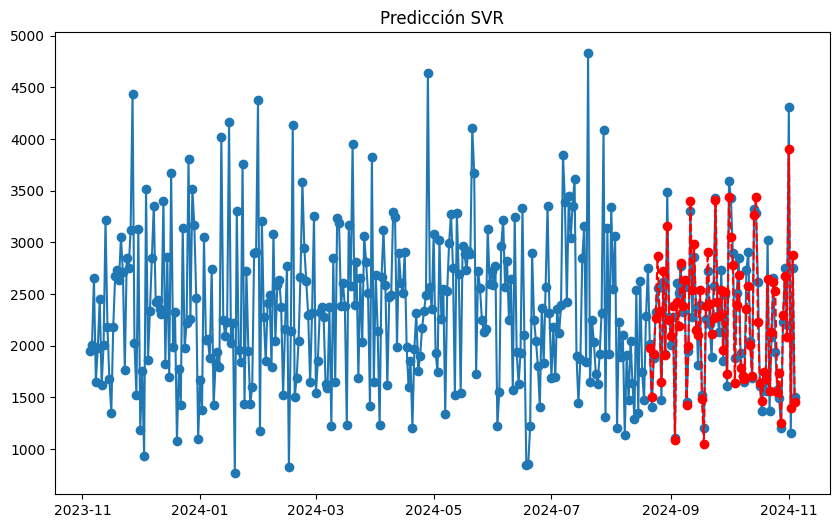

In [37]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Total_Sales'], label='Ventas Reales', marker='o')
plt.plot(test.index, svr_pred, label='Predicción SVR', linestyle='dashed', marker='o', color='red')
plt.title('Predicción SVR');

### Ridge

In [38]:
ridge = Ridge(solver="sag")

ridge.fit(X_train, y_train_log)

ridge_pred = ridge.predict(X_test)
ridge_pred = np.expm1(ridge_pred)

mape = mean_absolute_percentage_error(y_test,ridge_pred)
rmse = root_mean_squared_error(y_test,ridge_pred)
mae = mean_absolute_error(y_test,ridge_pred)
print(f'MAPE: {mape*100:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
evaluar_modelo('Ridge',y_pred=ridge_pred,y_test=y_test)


MAPE: 8.32%
RMSE: 239.5098
MAE: 181.3870


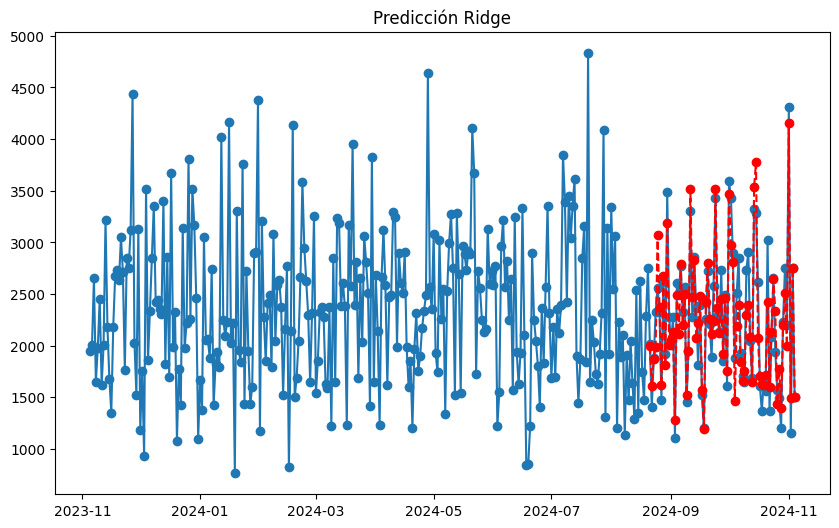

In [39]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Total_Sales'], label='Ventas Reales', marker='o')
plt.plot(test.index, ridge_pred, label='Predicción Ridge', linestyle='dashed', marker='o', color='red')
plt.title('Predicción Ridge');

### BayesianRidge

In [40]:
b_ridge = BayesianRidge()

b_ridge.fit(X_train, y_train_log)

b_ridge_pred = b_ridge.predict(X_test)
b_ridge_pred = np.expm1(b_ridge_pred)

rmse = root_mean_squared_error(y_test,b_ridge_pred)
mae = mean_absolute_error(y_test,b_ridge_pred)
mape = mean_absolute_percentage_error(y_test,b_ridge_pred)
print(f'MAPE: {mape*100:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
evaluar_modelo('BayesianRidge',y_pred=b_ridge_pred,y_test=y_test)

MAPE: 6.68%
RMSE: 195.3515
MAE: 149.6835


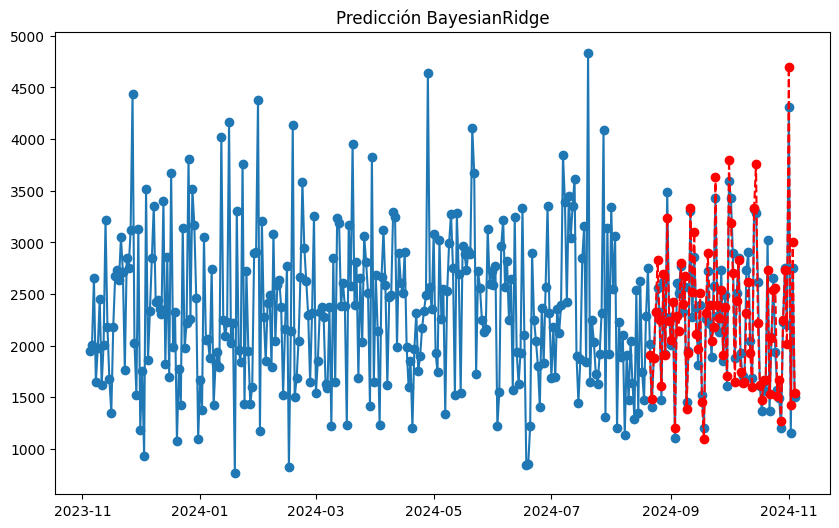

In [41]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Total_Sales'], label='Ventas Reales', marker='o')
plt.plot(test.index, b_ridge_pred, label='Predicción BayesianRidge', linestyle='dashed', marker='o', color='red')
plt.title('Predicción BayesianRidge');

### LASSO

In [42]:
lasso = Lasso()

lasso.fit(X_train, y_train)

lasso_pred = lasso.predict(X_test)

rmse = root_mean_squared_error(y_test,lasso_pred)
mae = mean_absolute_error(y_test,lasso_pred)
mape = mean_absolute_percentage_error(y_test,lasso_pred)
print(f'MAPE: {mape*100:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
evaluar_modelo('Lasso',y_pred=lasso_pred,y_test=y_test)

MAPE: 6.60%
RMSE: 183.7285
MAE: 144.8262


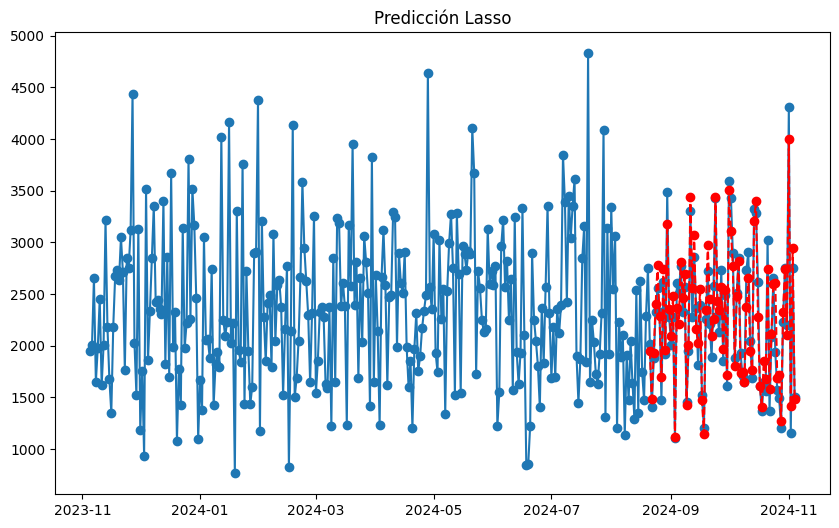

In [43]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Total_Sales'], label='Ventas Reales', marker='o')
plt.plot(test.index, lasso_pred, label='Predicción Lasso', linestyle='dashed', marker='o', color='red')
plt.title('Predicción Lasso');

### ElasticNet

In [44]:
enet = ElasticNet()

enet.fit(X_train, y_train)

enet_pred = enet.predict(X_test)

rmse = root_mean_squared_error(y_test,enet_pred)
mae = mean_absolute_error(y_test,enet_pred)
mape = mean_absolute_percentage_error(y_test,enet_pred)
print(f'MAPE: {mape*100:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

evaluar_modelo('ElasticNet',y_pred=enet_pred,y_test=y_test)

MAPE: 6.65%
RMSE: 184.0047
MAE: 145.3976


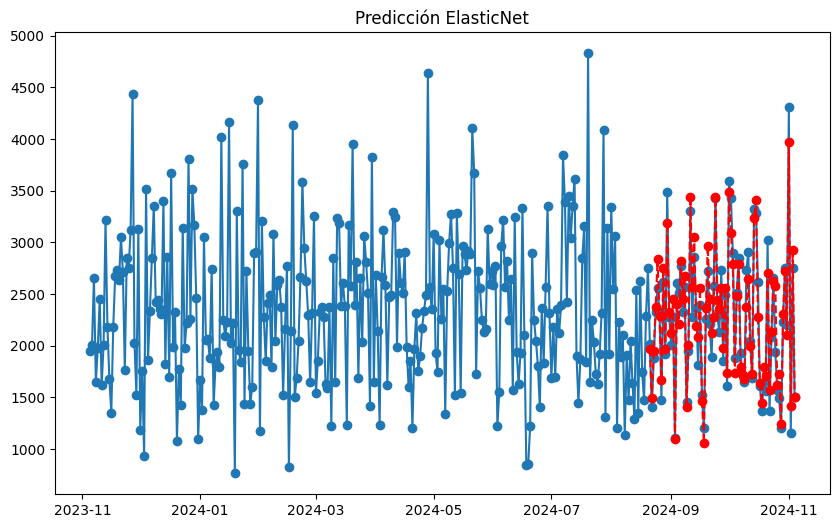

In [45]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Total_Sales'], label='Ventas Reales', marker='o')
plt.plot(test.index, enet_pred, label='Predicción ElasticNet', linestyle='dashed', marker='o', color='red')
plt.title('Predicción ElasticNet');

In [46]:
stacking_clf = StackingRegressor(
    estimators=[
        ('lr', LinearRegression()),
        ('rf',  RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)),
        ('b_ridge', BayesianRidge()),
        ('lasso', Lasso()),
        ('enet', ElasticNet()),
    ],
    final_estimator=Ridge(alpha=1.0, solver="sag"),
    cv=3  # número de folds en validación cruzada
)
stacking_clf.fit(X_train, y_train_log)
stacking_pred = stacking_clf.predict(X_test)
stacking_pred = np.expm1(stacking_pred)

rmse_stack = root_mean_squared_error(y_test,stacking_pred)
mae_stack = mean_absolute_error(y_test,stacking_pred)
r2_stack = r2_score(y_test, stacking_pred)
mape = mean_absolute_percentage_error(y_test,stacking_pred)
print(f'MAPE: {mape*100:.2f}%')
print(f'RMSE: {rmse_stack:.4f}')
print(f'MAE: {mae_stack:.4f}')
print(f'R² Score: {r2_stack:.4f}')
evaluar_modelo('StackingRegressor',y_pred=stacking_pred,y_test=y_test)

MAPE: 6.38%
RMSE: 176.8545
MAE: 138.5033
R² Score: 0.9274


In [47]:
stacking_train_pred = stacking_clf.predict(X_train)
stacking_train_pred = np.expm1(stacking_train_pred)
residuos_train = y_train - stacking_train_pred

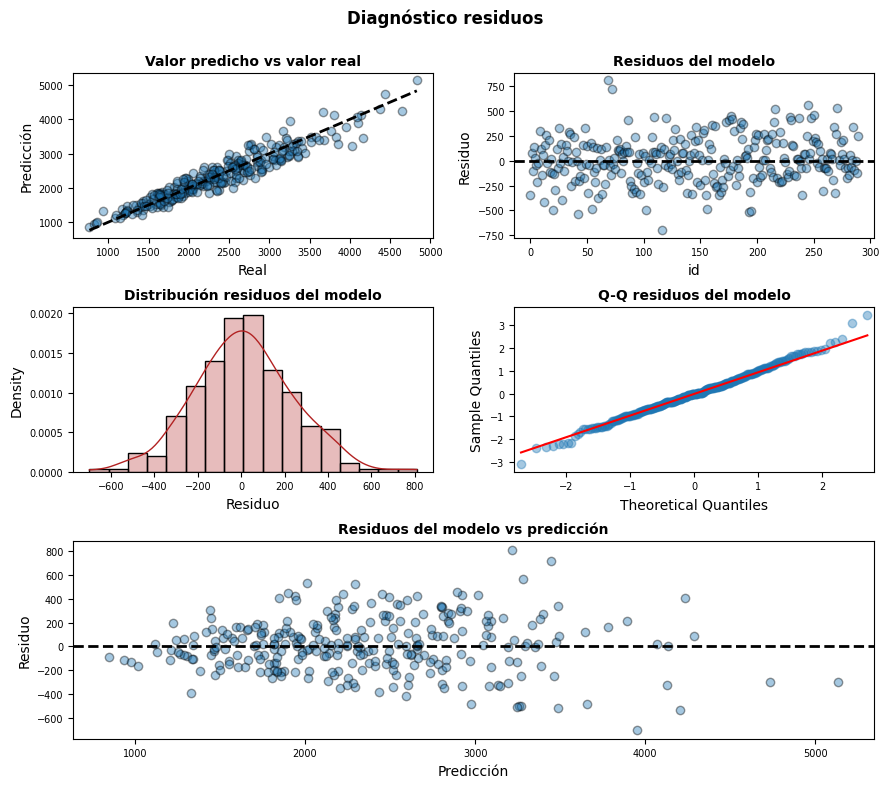

In [48]:
fig = plt.figure(figsize=(9, 8))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1.2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_train, stacking_train_pred, edgecolors=(0, 0, 0), alpha=0.4)
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
ax1.set_title('Valor predicho vs valor real', fontsize=10, fontweight="bold")
ax1.set_xlabel('Real')
ax1.set_ylabel('Predicción')
ax1.tick_params(labelsize=7)

# Gráfico 2: Residuos del modelo
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(list(range(len(y_train))), residuos_train, edgecolors=(0, 0, 0), alpha=0.4)
ax2.axhline(y=0, linestyle='--', color='black', lw=2)
ax2.set_title('Residuos del modelo', fontsize=10, fontweight="bold")
ax2.set_xlabel('id')
ax2.set_ylabel('Residuo')
ax2.tick_params(labelsize=7)

# Gráfico 3: Distribución de residuos
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(data=residuos_train, stat="density", kde=True, line_kws={'linewidth': 1},
             color="firebrick", alpha=0.3, ax=ax3)
ax3.set_title('Distribución residuos del modelo', fontsize=10, fontweight="bold")
ax3.set_xlabel("Residuo")
ax3.tick_params(labelsize=7)

# Gráfico 4: Q-Q Plot
ax4 = fig.add_subplot(gs[1, 1])
sm.qqplot(residuos_train, fit=True, line='q', ax=ax4, color='firebrick', alpha=0.4, lw=2)
ax4.set_title('Q-Q residuos del modelo', fontsize=10, fontweight="bold")
ax4.tick_params(labelsize=7)

# Gráfico 5: Residuos vs Predicción (Centrado)
ax5 = fig.add_subplot(gs[2, :])
ax5.scatter(stacking_train_pred, residuos_train, edgecolors=(0, 0, 0), alpha=0.4)
ax5.axhline(y=0, linestyle='--', color='black', lw=2)
ax5.set_title('Residuos del modelo vs predicción', fontsize=10, fontweight="bold")
ax5.set_xlabel('Predicción')
ax5.set_ylabel('Residuo')
ax5.tick_params(labelsize=7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize=12, fontweight="bold")
plt.show()

In [49]:
from scipy.stats import shapiro

stat, p = shapiro(residuos_train)
print(f'Estadística={stat:.4f}, p-valor={p:.4f}')

if p > 0.05:
    print("✅ Los residuos siguen una distribución normal (p > 0.05)")
else:
    print("❌ Los residuos NO siguen una distribución normal (p < 0.05)")

Estadística=0.9959, p-valor=0.6491
✅ Los residuos siguen una distribución normal (p > 0.05)


ExactExplainer explainer: 77it [00:33,  2.25it/s]                        


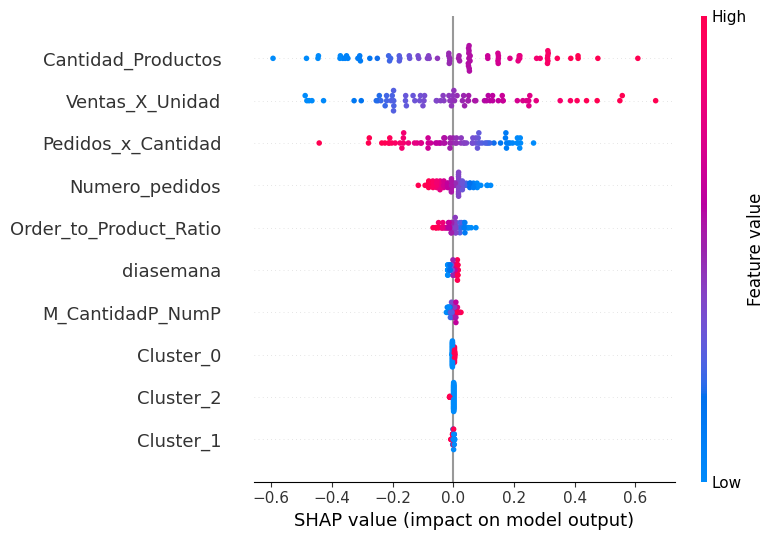

In [50]:
explainer = shap.Explainer(stacking_clf.predict, X_test)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test);

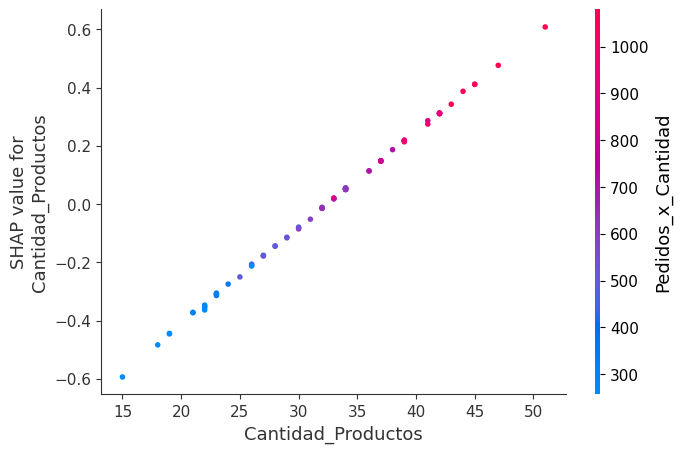

In [51]:
shap_values_array = shap_values.values

shap.dependence_plot('Cantidad_Productos', shap_values_array, X_test)

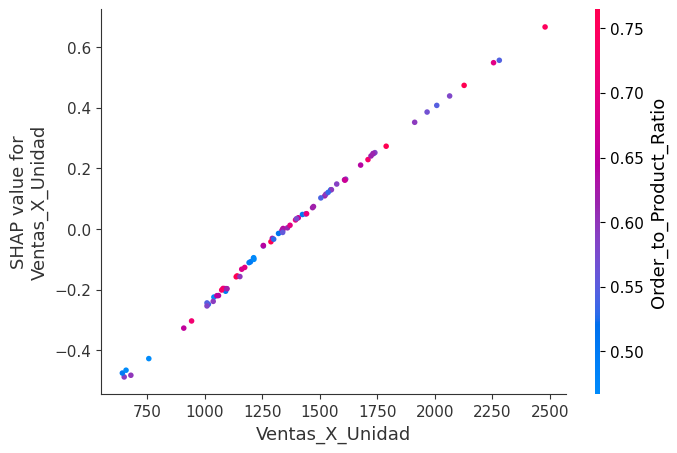

In [52]:
shap.dependence_plot('Ventas_X_Unidad', shap_values_array, X_test)